In [24]:
import os
import pyspark
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
from pyspark.sql.functions import col
from pyspark.sql.types import StructField
from pyspark.sql.types import IntegerType
from pyspark.sql.types import TimestampType
from pyspark.sql.types import StringType
from pyspark.sql.types import FloatType
from pyspark.sql.functions import col, expr
from pyspark.sql import functions as f
from pyspark.sql.functions import when
import matplotlib.pyplot as plt
conf = pyspark.SparkConf()
spark = SparkSession.builder.appName("Rank").getOrCreate()

ConnectionRefusedError: [Errno 61] Connection refused

In [2]:
df1=spark.read.parquet("/Users/abhishek/Documents/Cleansed/Parquet/*")

In [4]:
df1.createOrReplaceTempView("Load")

# Ranking Rule 1

In [5]:
df_rule_1 = spark.sql("SELECT buyer, AVG(usd_amount) AS buying FROM Load GROUP BY buyer")

In [9]:
df_rule_1 = df_rule_1.withColumn("score1", expr("ntile(5) over (order by buying)"))

In [11]:
pandas_df = df_rule_1.toPandas()

23/03/22 17:45:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/22 17:45:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/22 17:45:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/03/22 17:45:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/22 17:45:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/22 17:45:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/22 17:45:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


# Ranking Rule 2

In [14]:
df_rule_2 = spark.sql("SELECT buyer, COUNT(buyer) AS NTran FROM Load GROUP BY buyer")

In [16]:
# Rule to be changed later on: Manually assign the score of 1 to all NTran = 1, score of 2 to NTran = 2-5, and 5 only to top 10%

df_rule_2 = df_rule_2.withColumn("score2", expr("ntile(5) over (order by NTran)"))

# Ranking Rule 3

In [19]:
df_rule_3 = spark.sql("SELECT buyer, COUNT(platform) AS Platform FROM Load GROUP BY buyer")

In [21]:
df_rule_3 = df_rule_3.withColumn("score3", expr("ntile(5) over (order by Platform)"))

# Ranking Rule 4 and 5

In [23]:
# Formulated in different sheet - Priyanka

# Aggregation

In [89]:
merged_df = df_rule_1.join(df_rule_2, on='buyer').join(df_rule_3, on='buyer')

In [98]:
merged_df = merged_df.withColumn("score1", merged_df["score1"].cast('int'))
merged_df = merged_df.withColumn("score2", merged_df["score2"].cast('int'))
merged_df = merged_df.withColumn("score3", merged_df["score3"].cast('int'))

In [102]:
merged_df.na.drop()

DataFrame[buyer: string, buying: double, score: int, score1: int, NTran: bigint, score2: int, Platform: bigint, score3: int]

In [107]:
merged_df = merged_df.withColumn( "FScore", merged_df["score1"] + merged_df["score2"] + merged_df["score3"] )

In [119]:
merged_df = merged_df.withColumn("Tier", expr("ntile(3) over (order by FScore)"))

In [124]:
final_df = merged_df.select('buyer', 'FScore', 'Tier')

In [127]:
final_df.write.parquet("/Users/abhishek/Documents/Membership/Parquet")

23/03/21 06:54:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 06:54:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 06:54:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 06:54:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 06:54:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 06:54:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 0

23/03/21 06:54:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 06:54:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 06:54:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 06:54:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 06:54:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 06:54:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 0

23/03/21 06:54:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 06:54:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 06:54:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 06:54:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 06:54:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 06:54:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 0

23/03/21 06:54:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 06:54:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 06:54:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 06:54:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 06:54:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 06:54:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 0

In [37]:
df_all = spark.sql("SELECT * FROM ( SELECT n1.buyer, n1.original_currency, n1.nft_token_id, n1.nft_contract_address, n1.original_amount as Bought, n2.original_amount as Sold, n1.block_time as Bought_Timestamp, n2.block_time as Sold_Timestamp,n1.usd_amount as Bought_amount, n2.usd_amount as Sold_amount, (n2.usd_amount - n1.usd_amount) as net, n1.platform as n1platform, n2.platform as n2platform FROM Load n1, Load n2 where n1.buyer = n2.seller AND  n2.block_time > n1.block_time AND  n1.nft_token_id is not null AND n1.nft_token_id = n2.nft_token_id AND n1.nft_contract_address = n2.nft_contract_address) holdings")

In [38]:
type(df_all)

pyspark.sql.dataframe.DataFrame

In [39]:
data_collect = df_all.collect()
buyer_nft_contract_address_dict = {}
for row in data_collect:
    if row['buyer'] not in buyer_nft_contract_address_dict:
        listnew = []
        listnew.append(row['nft_contract_address'])
        buyer_nft_contract_address_dict[row['buyer']] = list(set(listnew))
        listnew.clear()
    else:
        listnftcontracts = []
        listnftcontracts = buyer_nft_contract_address_dict[row['buyer']]
        listnftcontracts.append(row['nft_contract_address'])
        buyer_nft_contract_address_dict[row['buyer']] = list(set(listnftcontracts))
        listnftcontracts.clear()
    

In [40]:
buyer_nft_contract_address_count_dict = {}
for key, value in buyer_nft_contract_address_dict.items():
    buyer_nft_contract_address_count_dict[key] = len(value)

In [41]:
diversity_bins = {'bin1':0, 'bin2':0, 'bin3':0, 'bin4':0, 'bin5':0}
for key, value in buyer_nft_contract_address_count_dict.items():
    if value <= 1:
        diversity_bins['bin1'] = diversity_bins['bin1'] + 1
    if value > 1:
        diversity_bins['bin2'] = diversity_bins['bin2'] + 1
    
    

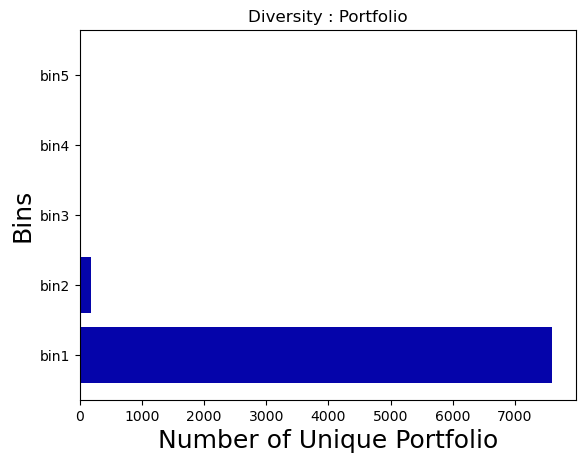

In [42]:
names = list(diversity_bins.keys())
values = list(diversity_bins.values())
plt.barh(range(len(diversity_bins)), values , tick_label=names, color='#0504aa', align='center')
plt.title('Diversity : Portfolio')
plt.ylabel('Bins', fontsize=18)
plt.xlabel('Number of Unique Portfolio', fontsize=18)
plt.show()